In [ ]:
!pip install gensim pyLDAvis

In [ ]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import sys
import os
import gensim, spacy, logging, warnings
import pyLDAvis
import pyLDAvis.gensim_models
from matplotlib.ticker import PercentFormatter
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import mac_morpho
from nltk.tag import UnigramTagger
from nltk.stem import WordNetLemmatizer
from pathlib import Path
from pprint import pprint
from tqdm import tqdm
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

In [ ]:
# Configurações pandas
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 1000 #60 o padrão

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('mac_morpho')
stopwords_portuguese = nltk.corpus.stopwords.words('portuguese')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Unzipping corpora/mac_morpho.zip.


# Pré-processamento

In [ ]:
# Lendo o arquivo xlsx
df = pd.read_excel("/content/DMAE.xlsx")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,DATA,VEÍCULO,ASSUNTO,pp_Assunto
0,2022-01-01,WEB – V9,"Ruim para o bolso: conta de água terá reajuste de 10,96% em Uberlândia",ruim bolso conta água reajuste uberlândia
1,2022-01-03,G1,Obras em Uberlândia: balanço aponta mais de 80 intervenções no município em 2021,obras uberlândia balanço aponta intervenções município
2,2022-01-03,TV VITORIOSA - CHUMBO GROSSO,André Silva reclama que o Dmae não se preocupa com a população e corta a água mesmo se não pagar.,andré silva reclama dmae preocupa população corta água pagar
3,2022-01-03,G1,Mudança de titularidade da fatura de água e esgoto pode ser feita pela internet em Uberlândia,mudança titularidade fatura água esgoto pode feita internet uberlândia
4,2022-01-03,RÁDIO VITORIOSA - MANHÃ VITORIOSA,"Reajustes - Lourival diz que a prefeitura irá aumentar a taxa de lixo e água em 10,98%.",reajustes lourival diz prefeitura irá aumentar taxa lixo água
5,2022-01-03,RÁDIO VITORIOSA - MANHÃ VITORIOSA,"Ouvinte reclama de contêiner de lixo que fica tão cheio que fica caindo para fora, dando a impressão de ser um ecoponto. Afirma que o povo da cidade perdeu a educação.",ouvinte reclama contêiner lixo fica tão cheio fica caindo dando impressão ecoponto afirma povo cidade perdeu educação
6,2022-01-03,RÁDIO VITORIOSA - MANHÃ VITORIOSA,"Ouvinte reclama que estão colocando cargos comissionados no Dmae, com salários de secretários e enquanto isso não estão convocando os cidadãos aprovados em concurso.",ouvinte reclama colocando cargos comissionados dmae salários secretários enquanto convocando cidadãos aprovados concurso
7,2022-01-03,TV INTEGRAÇÃO - MG 1,Transferência de titularidade da conta do Dmae será feita pelo site. Informa o site.,transferência titularidade conta dmae feita site informa site
8,2022-01-03,TV BAND - MINAS URGENTE,Obra do Dmae causa transtornos no Laranjeiras,obra dmae causa transtornos laranjeiras
9,2022-01-04,TV BAND - BORA MINAS,Aumento de imposots municipais,aumento imposots municipais


In [ ]:
# Transforma tudo em minúsculo
df['pp_Assunto'] = df['ASSUNTO'].apply(lambda x: x.lower())

# Remove pontuações
df['pp_Assunto'] = df['pp_Assunto'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

# Remove números
df['pp_Assunto'] = df['pp_Assunto'].apply(lambda x: re.sub('\d+', ' ', x))

# Remove palavras curtas
df['pp_Assunto'] = df['pp_Assunto'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

# Remove stopwords
df['pp_Assunto'] = df['pp_Assunto'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_portuguese)]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:8: DeprecationWarning: invalid escape sequence '\d'
<>:8: DeprecationWarning: invalid escape sequence '\d'
<ipython-input-13-6ec30fac85a3>:8: DeprecationWarning: invalid escape sequence '\d'
  df['pp_Assunto'] = df['pp_Assunto'].apply(lambda x: re.sub('\d+', ' ', x))


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATA        1570 non-null   datetime64[ns]
 1   VEÍCULO     1570 non-null   object        
 2   ASSUNTO     1570 non-null   object        
 3   pp_Assunto  1570 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 49.2+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Análise Descritiva

In [ ]:
# Quantidade de notícias por veículo
df_noticias_veiculos = df['VEÍCULO'].groupby(df['VEÍCULO']).count().sort_values(ascending=False).to_frame('Quantidade').reset_index()
df_noticias_veiculos['percentual_noticias'] = df_noticias_veiculos['Quantidade'].cumsum()/df_noticias_veiculos['Quantidade'].sum()*100

df_noticias_veiculos[0:211]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,VEÍCULO,Quantidade,percentual_noticias
0,RÁDIO VITORIOSA - MANHÃ VITORIOSA,96,6.114650
1,TV BAND - MINAS URGENTE,94,12.101911
2,TV INTEGRAÇÃO - MG1,85,17.515924
3,TV PARANAÍBA - JORNAL PARANAÍBA,81,22.675159
4,UBERLÂNDIA HOJE,76,27.515924
5,TV PARANAÍBA - BALANÇO GERAL,74,32.229299
6,TV BAND - BORA MINAS,69,36.624204
7,DIÁRIO DE UBERLÂNDIA,58,40.318471
8,REDE TV - ALERTA REGIONAL,48,43.375796
9,TV INTEGRAÇÃO - MG2,43,46.114650


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


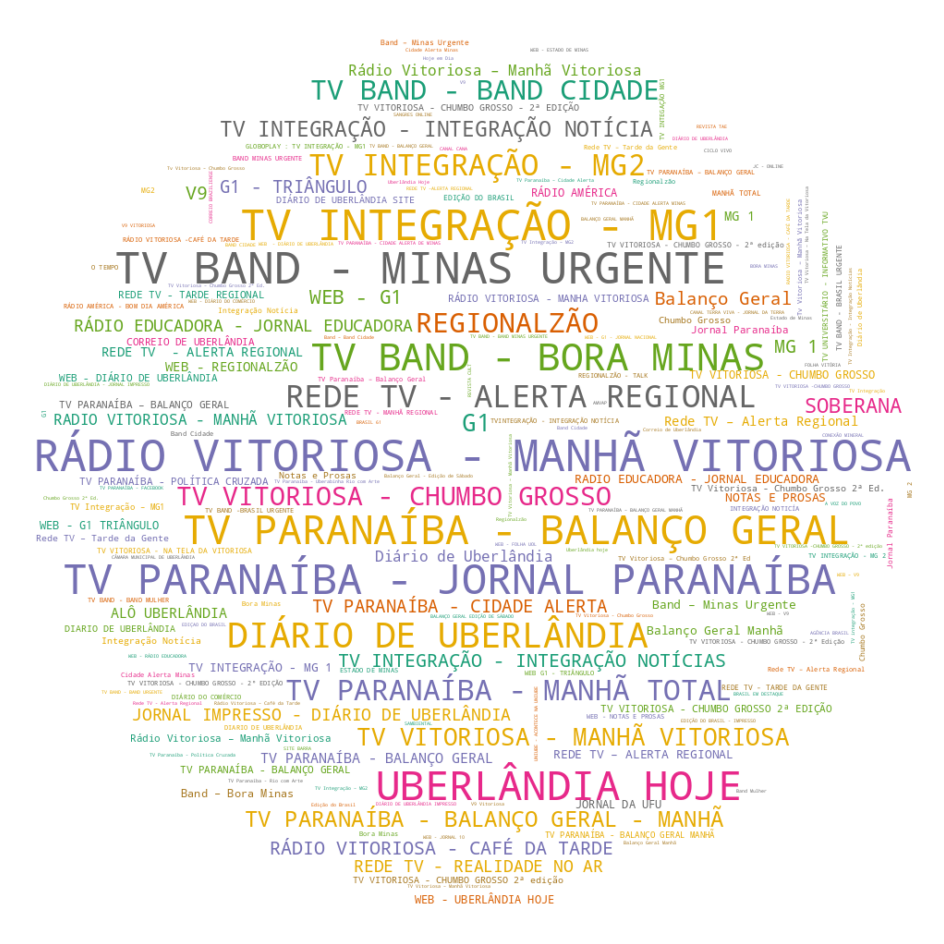

In [ ]:
# Nuvem de Palavras Veículos
d = {}

# Criando um dicionário com a frequência de notícias por veículo
for a, x, z in df_noticias_veiculos.values:
  d[a] = x

# Criando uma máscara
x, y = np.ogrid[:1000, :1000]
mask = (x - 500) ** 2 + (y - 500) ** 2 > 480 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(width = 800, height = 600, background_color='white', colormap='Dark2', mask=mask, random_state=2021)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Dias com picos de notícias

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 30.0)

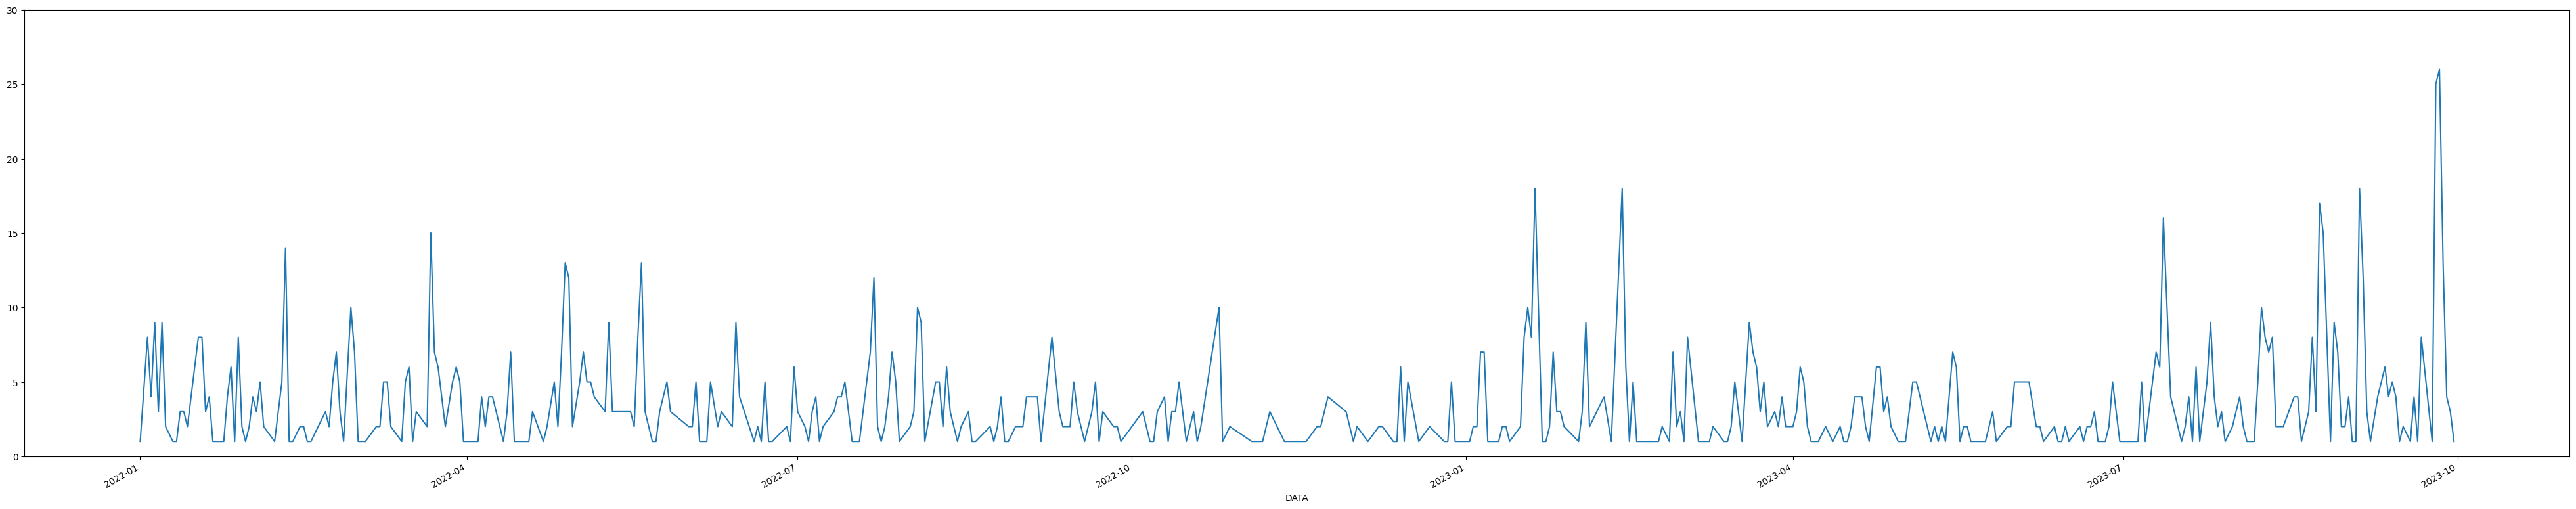

In [ ]:
df['DATA'].groupby([df['DATA']]).count().plot(kind='line', figsize=(50, 10)).set_ylim(0, 30)

### 1º Semestre - 2022

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 20.0)

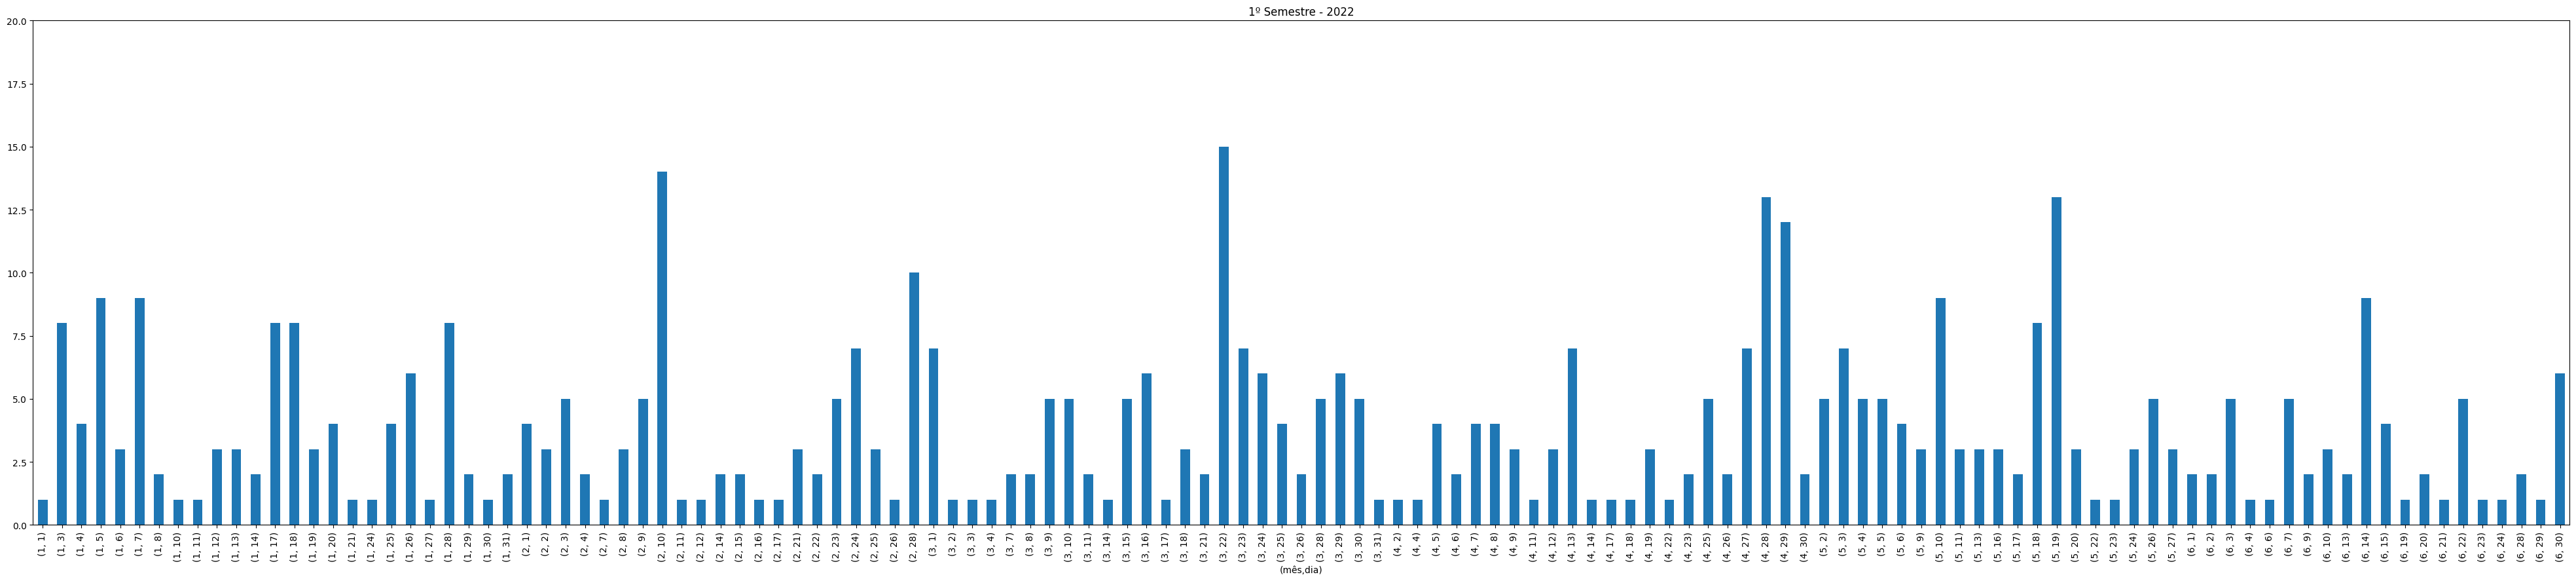

In [ ]:
df['DATA'][(df['DATA'].dt.year == 2022) & (df['DATA'].dt.month <= 6)].groupby([df['DATA'].dt.month.rename("(mês"), df['Data'].dt.day.rename("dia)")]).count().plot(
    kind='bar', figsize=(50, 10),title='1º Semestre - 2022').set_ylim(0, 20)

> 10/02

> 22/03

> 28 e 29/04

> 19/05

### 2º Semestre - 2022

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 20.0)

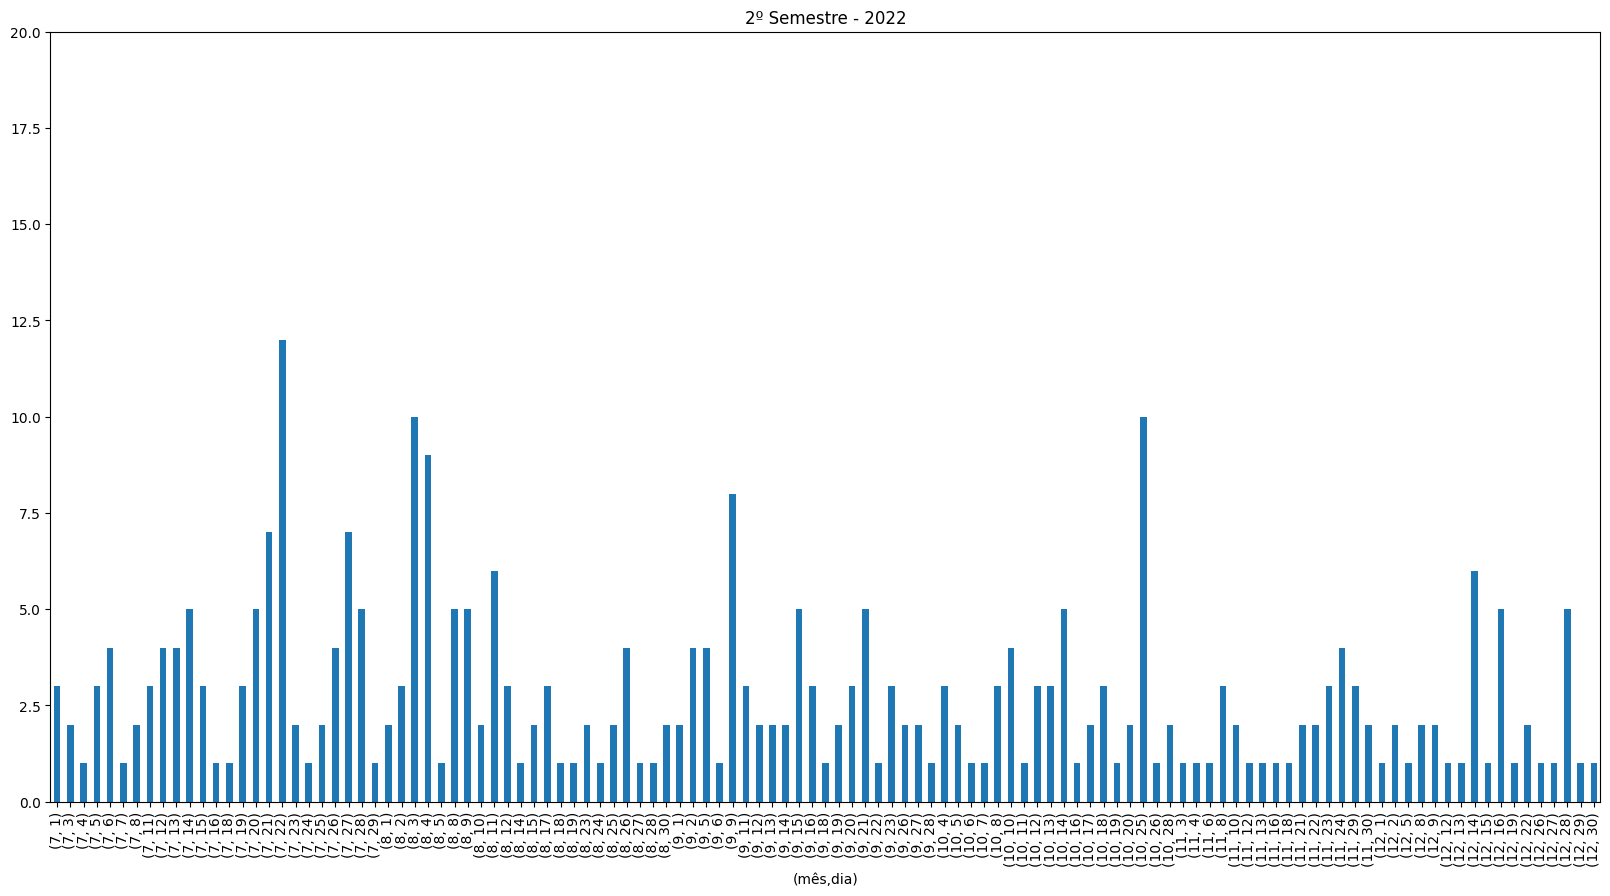

In [ ]:
df['DATA'][(df['DATA'].dt.year == 2022) & (df['DATA'].dt.month > 6)].groupby([df['DATA'].dt.month.rename("(mês"), df['DATA'].dt.day.rename("dia)")]).count().plot(
    kind='bar', figsize=(20, 10), title='2º Semestre - 2022').set_ylim(0, 20)

> 22/07

> 03 e 04/8

> 25/10

### 1º Semestre - 2023

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 30.0)

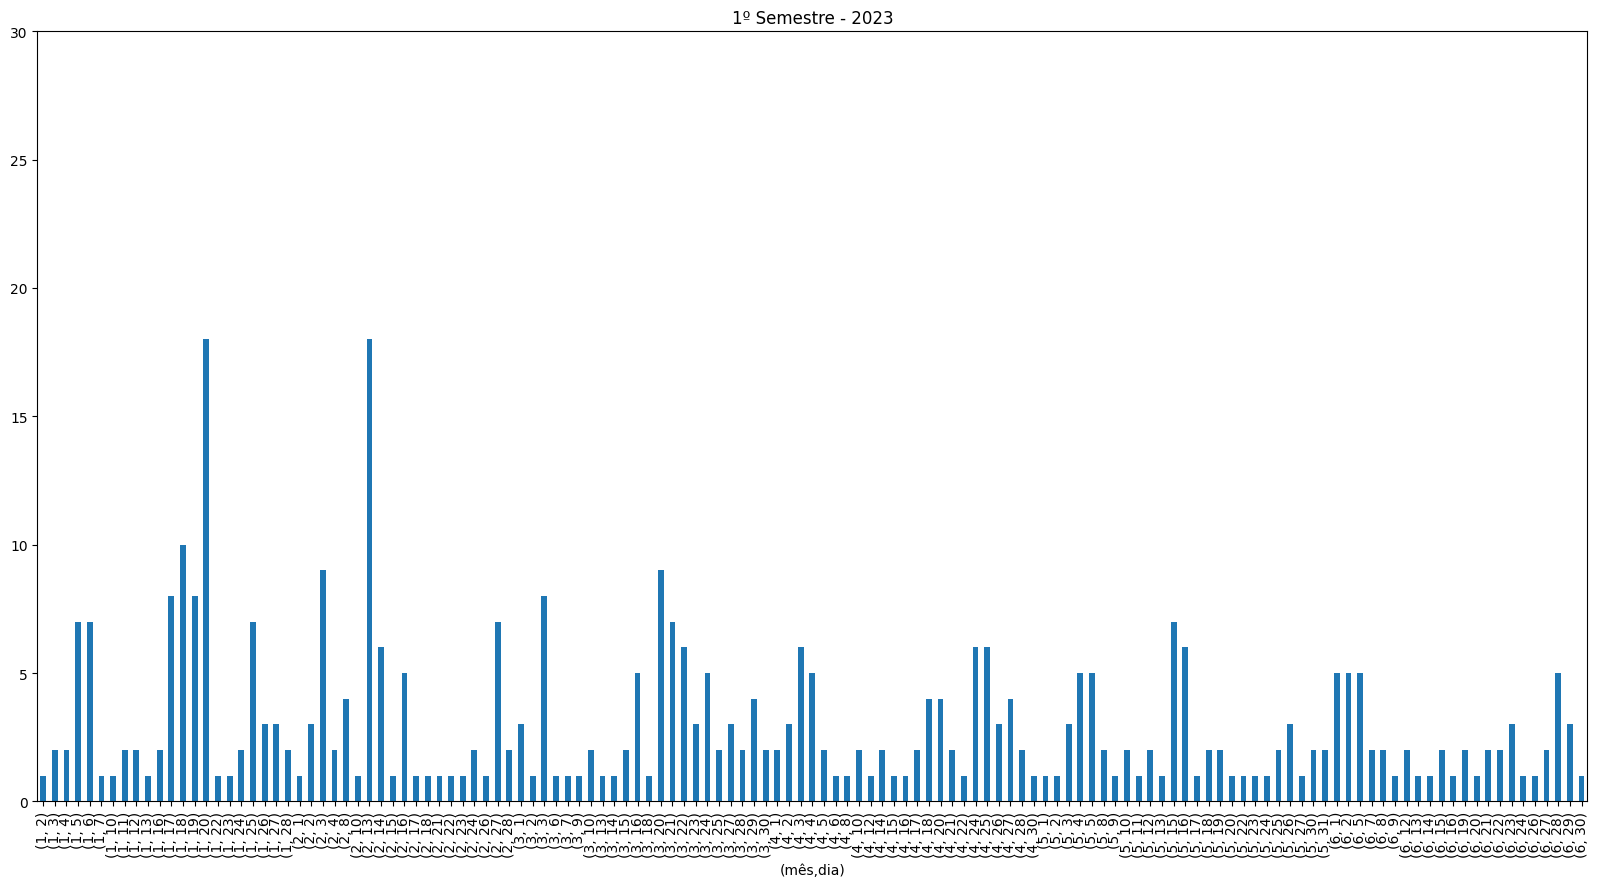

In [ ]:
df['DATA'][(df['DATA'].dt.year == 2023) & (df['DATA'].dt.month <= 6)].groupby([df['DATA'].dt.month.rename("(mês"), df['DATA'].dt.day.rename("dia)")]).count().plot(
    kind='bar', figsize=(20, 10), title='1º Semestre - 2023').set_ylim(0, 30)

> 20/01

> 13/02

### 2º Semestre - 2023

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 30.0)

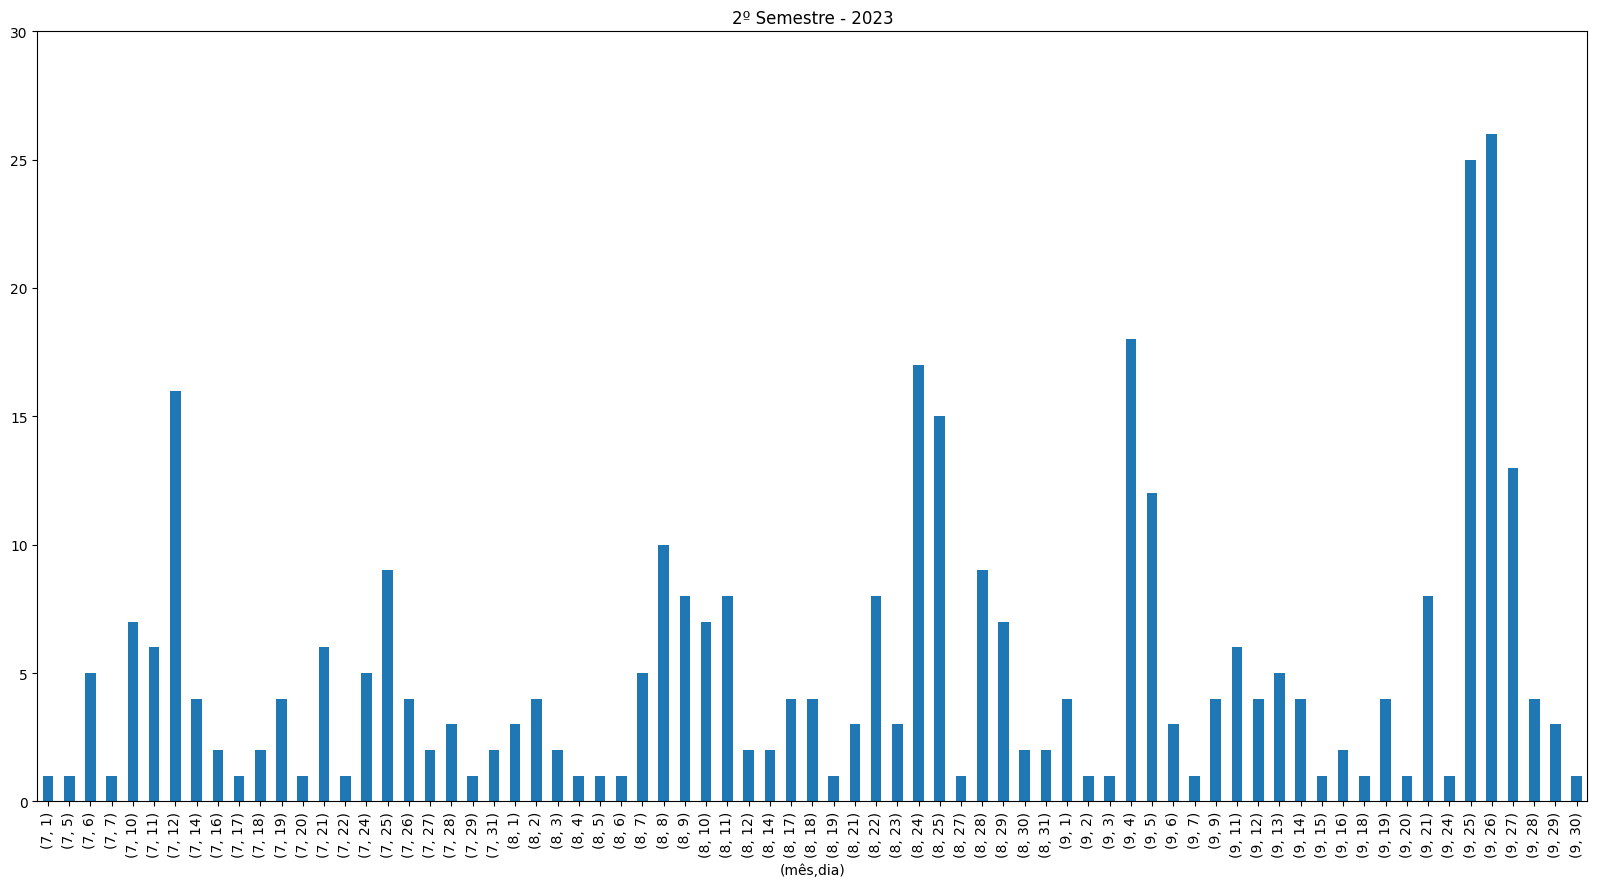

In [ ]:
df['DATA'][(df['DATA'].dt.year == 2023) & (df['DATA'].dt.month > 6)].groupby([df['DATA'].dt.month.rename("(mês"), df['DATA'].dt.day.rename("dia)")]).count().plot(
    kind='bar', figsize=(20, 10), title='2º Semestre - 2023').set_ylim(0, 30)

> 12/07

> 24 e 25/08

> 04/09

> 25 e 26/09

In [ ]:
# Dias com maior quantidade de notícias
df['DATA'].groupby(df['DATA']).count().sort_values(ascending=False)[0:30]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DATA
2023-09-26    26
2023-09-25    25
2023-01-20    18
2023-09-04    18
2023-02-13    18
2023-08-24    17
2023-07-12    16
2023-08-25    15
2022-03-22    15
2022-02-10    14
2023-09-27    13
2022-04-28    13
2022-05-19    13
2023-09-05    12
2022-07-22    12
2022-04-29    12
2022-08-03    10
2022-02-28    10
2023-08-08    10
2023-01-18    10
2022-10-25    10
2022-06-14     9
2022-08-04     9
2023-02-03     9
2023-03-20     9
2022-05-10     9
2023-07-25     9
2023-08-28     9
2022-01-07     9
2022-01-05     9
Name: DATA, dtype: int64

In [ ]:
df['ASSUNTO'][df["DATA"].isin(['2023-09-25', '2023-09-26'])]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1497                                                                                                                                                                                                                                 Falta de água em Uberlândia
1498                                                                                                                                                                                                                                   Furto de cabos de energia
1499                                                                                                                                                                                                                                Falta de água em Uberlândia 
1500                                                                                                                                                Com calor acima de 40ºC, bairros de Uberlândia ficam sem água e UFU recomenda sus

In [ ]:
df['ASSUNTO'][df["DATA"] == '2023-01-20']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


858                                                                                   Falta de água - - Moradores do bairro Martins afirmam estarem sem água para necessidades básicas.
859                                                                                                                                                                   Risco de tragédia
860                                                                                                                   Cratera - -Asfalto cede e grande buraco se abre no Bairro Lídice.
861                                                                                                                                                            Cratera no Bairro Lídice
862                                                                                                                                                                     “Buriti Cidade”
863                                                                             

## Nuvem de palavras das notícias

In [ ]:
# Lista para retirar palavras comuns
lista_palavras_comuns = ['bairro','bairros','diz', 'neste', 'pode', 'faz', 'fala', 'vai', 'fez', 'ter']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Geral

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


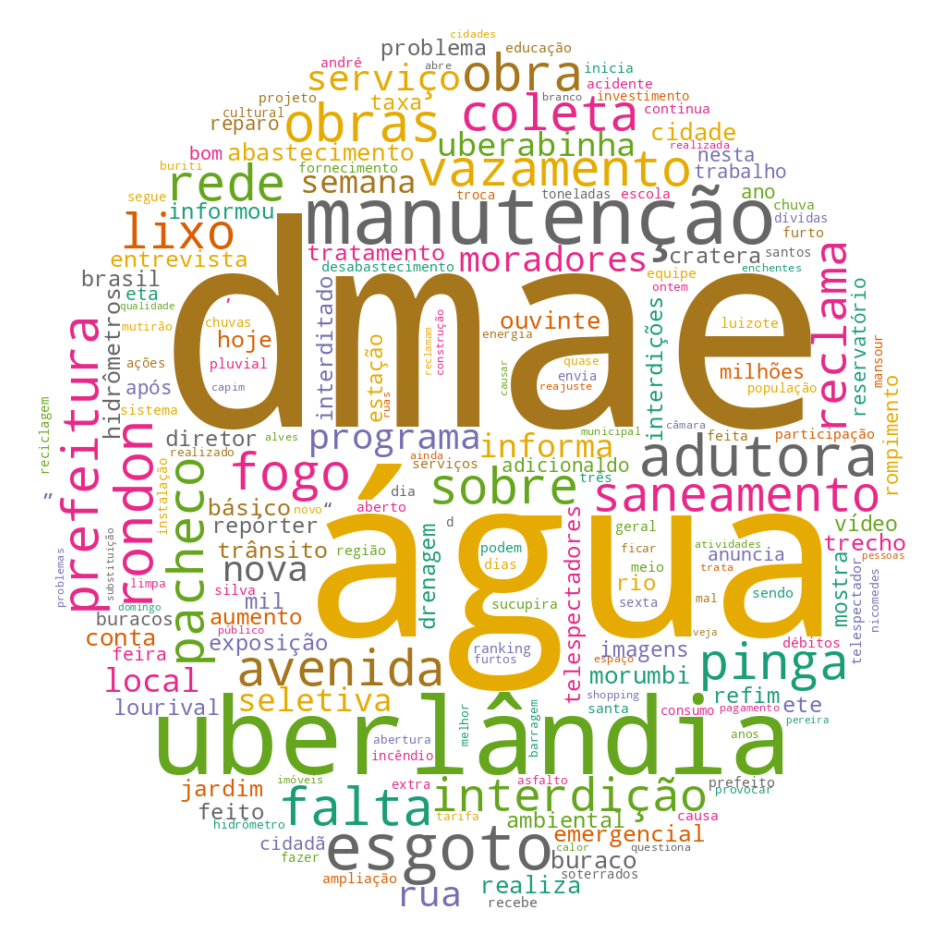

In [ ]:
str_noticias = ' '.join(df['pp_Assunto'])

str_noticias = ' '.join(x for x in str_noticias.split() if x not in lista_palavras_comuns)

tokens = nltk.word_tokenize(str_noticias)
frequencia = nltk.FreqDist(tokens)

wordcloud = WordCloud(width = 800, height = 600, background_color='white', colormap='Dark2', mask=mask, random_state=2022)
wordcloud.generate_from_frequencies(frequencies=frequencia)
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Períodos de pico

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


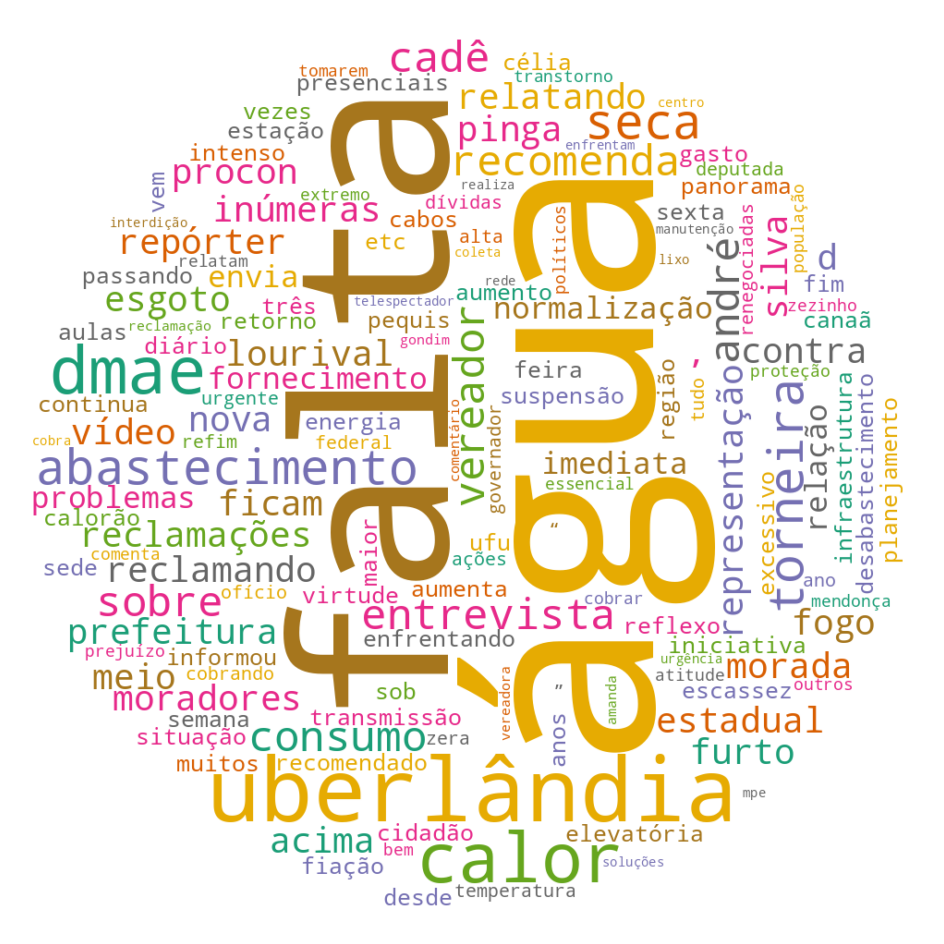

In [ ]:
str_noticias = ' '.join(
    df['pp_Assunto']
    [df['DATA'].isin(['2023-09-25', '2023-09-26'])]
)

str_noticias = ' '.join(x for x in str_noticias.split() if x not in lista_palavras_comuns)

tokens = nltk.word_tokenize(str_noticias)
frequencia = nltk.FreqDist(tokens)

wordcloud = WordCloud(width = 800, height = 600, background_color='white', colormap='Dark2', mask=mask, random_state=2022)
wordcloud.generate_from_frequencies(frequencies=frequencia)
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# PoS Tagging e Ngrams

In [ ]:
str_noticias = ' '.join(df['pp_Assunto'])
str_noticias = ' '.join(x for x in str_noticias.split() if x not in lista_palavras_comuns)

tokens = nltk.word_tokenize(str_noticias)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tagger0 = nltk.DefaultTagger('N')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sentencas_treino = mac_morpho.tagged_sents()
etiquetador = UnigramTagger(sentencas_treino, backoff=tagger0)

etiquetado = etiquetador.tag(tokens)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tags = [tag for (word, tag) in etiquetado]
frequent_tags = nltk.FreqDist(tags)
#list(frequent_tags.keys())[0:20]
frequent_tags.most_common(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('N', 8582),
 ('V', 1334),
 ('ADJ', 727),
 ('PCP', 431),
 ('ADV', 153),
 ('PREP', 133),
 ('VAUX', 82),
 ('NUM', 81),
 ('PROADJ', 62),
 ('PREP|+', 40)]

## Substantivos mais comuns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


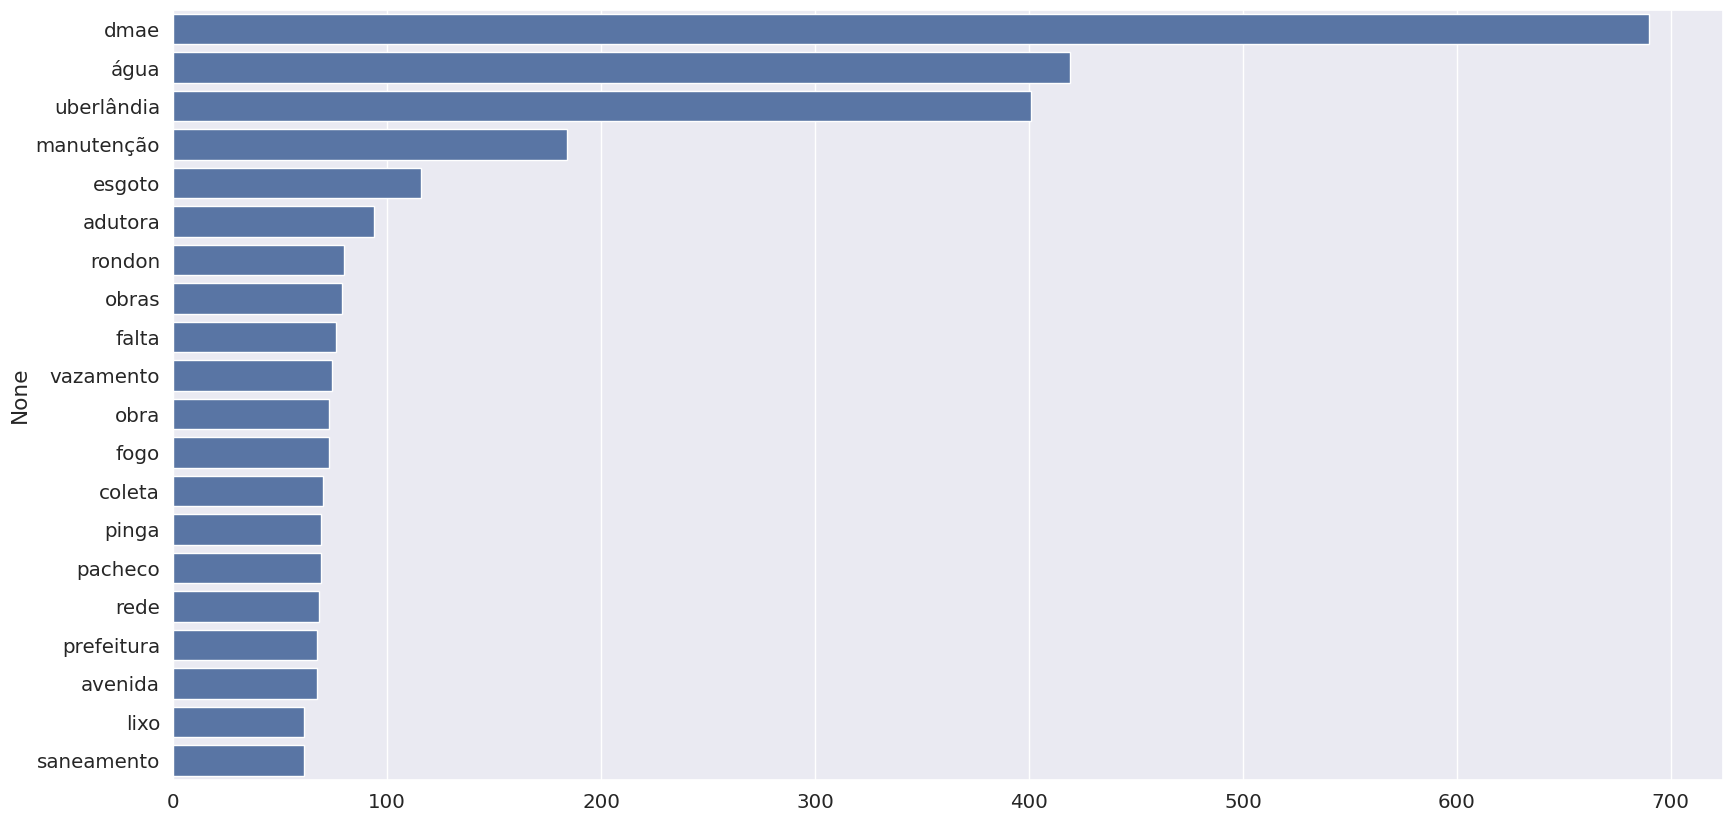

In [ ]:
words = [word for (word, tag) in etiquetado if tag == 'N']
frequent_words = nltk.FreqDist(words)
#frequent_words.most_common(10)

most_common_words = frequent_words.most_common(20)
most_common_words = pd.Series(dict(most_common_words))

#fig, ax = plt.subplots(figsize=(10,10))
#all_plot = sns.barplot(x=most_common_words.index, y=most_common_words.values, ax=ax)
#plt.xticks(rotation=30)

sns.set(font_scale = 1.3)
fig, ax = plt.subplots(figsize=(20,10))
all_plot = sns.barplot(y=most_common_words.index, x=most_common_words.values, ax=ax, orient='h')

## Verbos mais comuns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


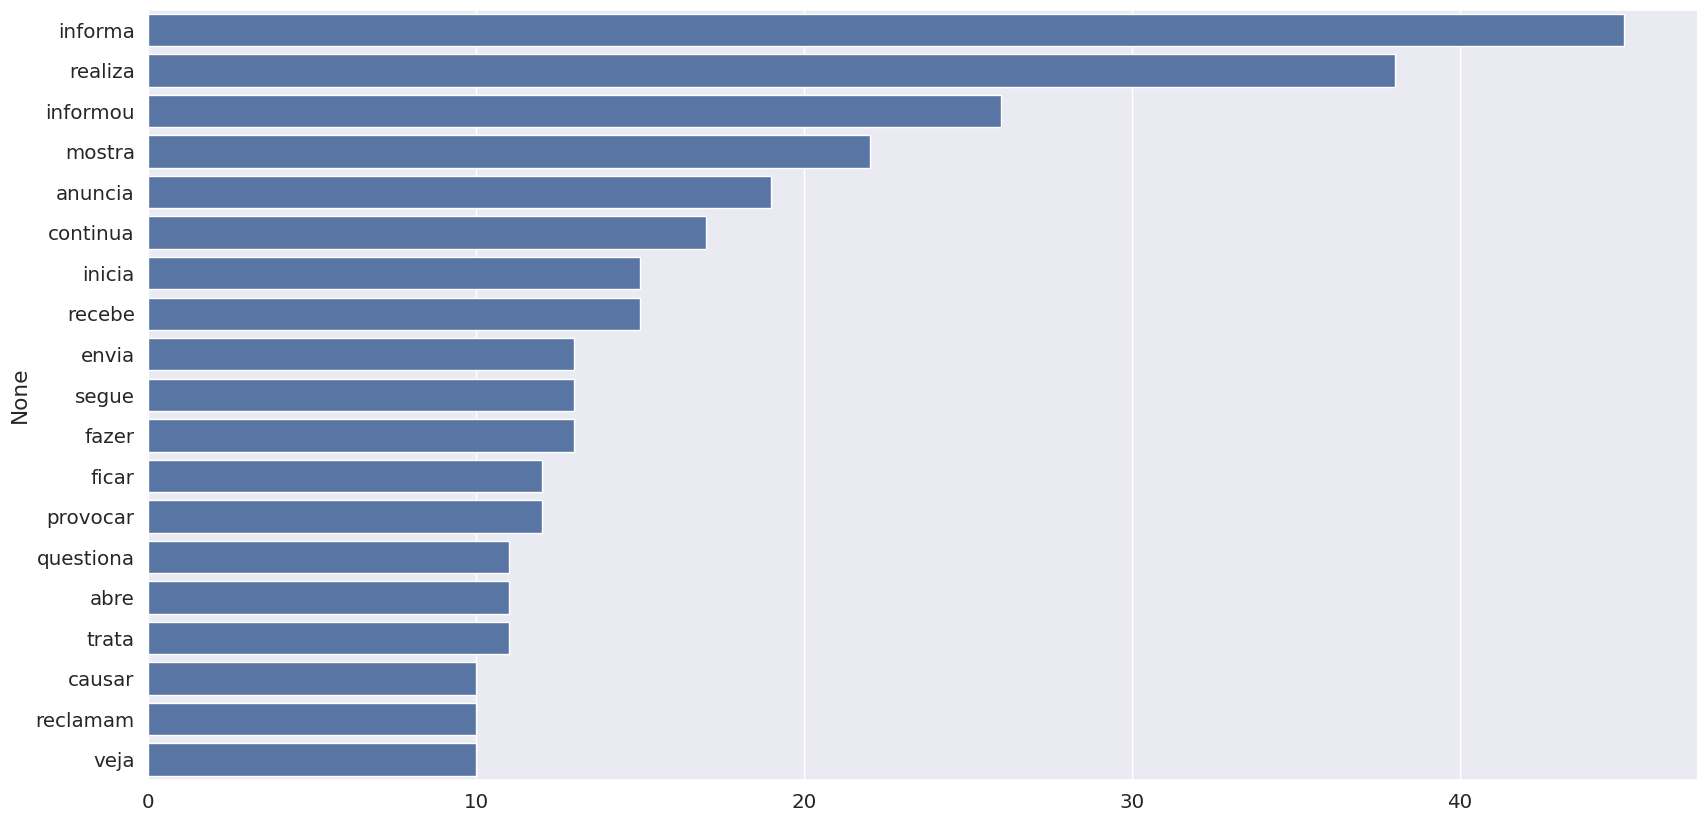

In [ ]:
words = [word for (word, tag) in etiquetado if tag == 'V']
frequent_words = nltk.FreqDist(words)
#frequent_words.most_common(10)

most_common_words = frequent_words.most_common(21)[1:20]
most_common_words = pd.Series(dict(most_common_words))

#fig, ax = plt.subplots(figsize=(10,10))
#all_plot = sns.barplot(x=most_common_words.index, y=most_common_words.values, ax=ax)
#plt.xticks(rotation=30)

sns.set(font_scale = 1.3)
fig, ax = plt.subplots(figsize=(20,10))
all_plot = sns.barplot(y=most_common_words.index, x=most_common_words.values, ax=ax, orient='h')

## Adjetivos mais comuns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


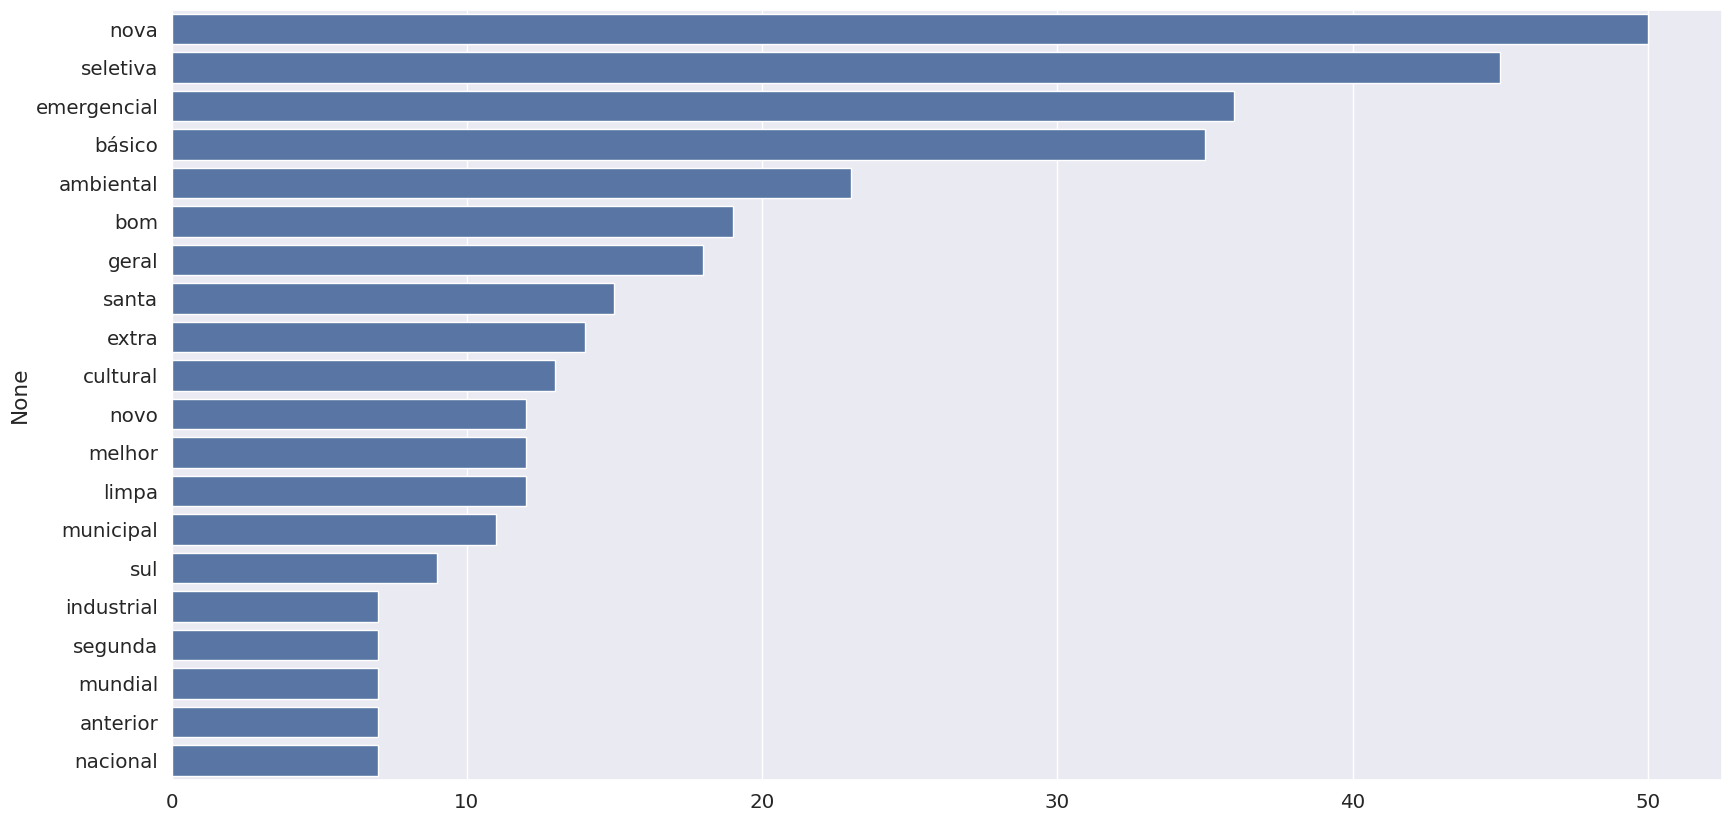

In [ ]:
words = [word for (word, tag) in etiquetado if tag == 'ADJ']
frequent_words = nltk.FreqDist(words)

most_common_words = frequent_words.most_common(20)
most_common_words = pd.Series(dict(most_common_words))

sns.set(font_scale = 1.3)
fig, ax = plt.subplots(figsize=(20,10))
all_plot = sns.barplot(y=most_common_words.index, x=most_common_words.values, ax=ax, orient='h')

## Palavras mais frequentes

In [ ]:
frequent_words.most_common(30)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('nova', 50),
 ('seletiva', 45),
 ('emergencial', 36),
 ('básico', 35),
 ('ambiental', 23),
 ('bom', 19),
 ('geral', 18),
 ('santa', 15),
 ('extra', 14),
 ('cultural', 13),
 ('novo', 12),
 ('melhor', 12),
 ('limpa', 12),
 ('municipal', 11),
 ('sul', 9),
 ('industrial', 7),
 ('segunda', 7),
 ('mundial', 7),
 ('anterior', 7),
 ('nacional', 7),
 ('alto', 6),
 ('social', 6),
 ('próximo', 6),
 ('irregular', 6),
 ('oeste', 6),
 ('pública', 6),
 ('novos', 5),
 ('estadual', 5),
 ('novas', 5),
 ('grande', 5)]

## Bigramas

In [ ]:
lista_bigramas = list(nltk.bigrams(tokens))
frequent_bigramas = nltk.FreqDist(lista_bigramas)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


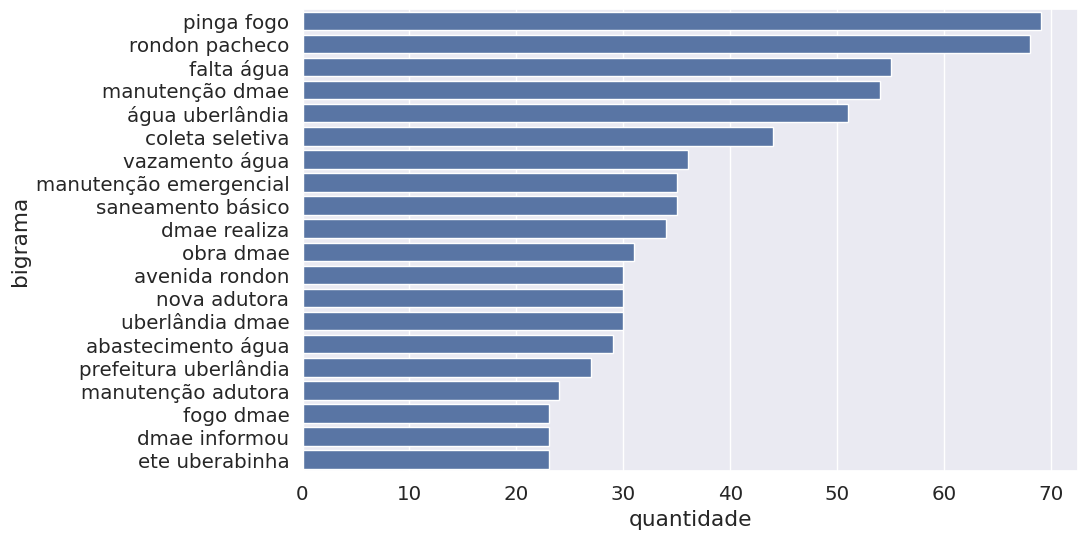

In [ ]:
most_common_bigrams = frequent_bigramas.most_common(20)
most_common_bigrams = pd.DataFrame((most_common_bigrams), columns=['bigrama', 'quantidade'])

sns.set(font_scale = 1.3)
fig, ax = plt.subplots(figsize=(10,6))
all_plot = sns.barplot(y=most_common_bigrams['bigrama'].apply(lambda x: ' '.join(x)), x=most_common_bigrams['quantidade'], ax=ax, orient='h')

## Trigramas

In [ ]:
lista_trigramas = list(nltk.trigrams(tokens))
frequent_trigramas = nltk.FreqDist(lista_trigramas)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


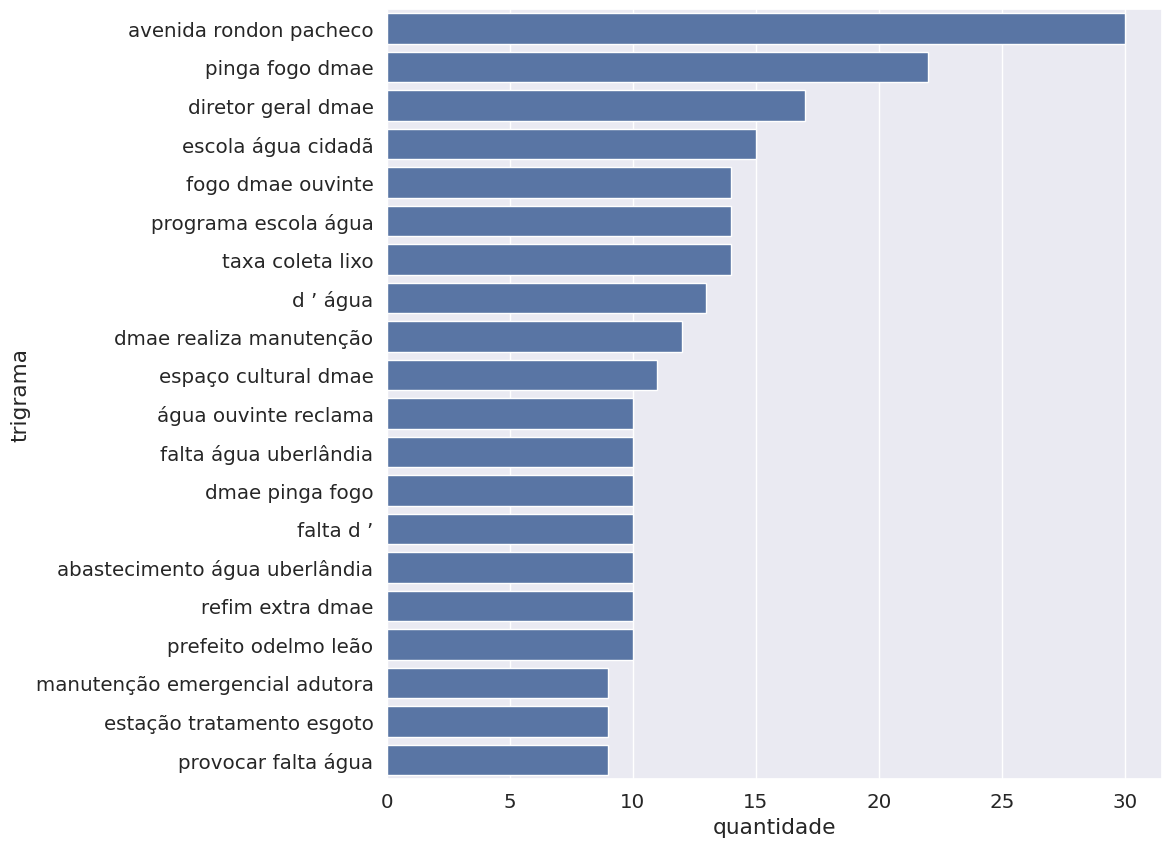

In [ ]:
most_common_trigrams = frequent_trigramas.most_common(20)
most_common_trigrams = pd.DataFrame((most_common_trigrams), columns=['trigrama', 'quantidade'])

sns.set(font_scale = 1.3)
fig, ax = plt.subplots(figsize=(10,10))
all_plot = sns.barplot(y=most_common_trigrams['trigrama'].apply(lambda x: ' '.join(x)), x=most_common_trigrams['quantidade'], ax=ax, orient='h')

# Tópicos

In [ ]:
noticias = df['pp_Assunto'].values.tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for index, x in enumerate(noticias):
    x = str(x)
    noticias[index] = ' '.join(word for word in x.split() if word not in lista_palavras_comuns)

In [ ]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

dados_palavras = list(sent_to_words(noticias))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Criando dicionário
id2word = corpora.Dictionary(dados_palavras)

# Criando corpus
texts = dados_palavras

# Frequencia do documento do termo
corpus = [id2word.doc2bow(text) for text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Construindo LDA Model
# Este processamento pode demorar
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=2022,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

doc_lda = lda_model[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pprint(lda_model.print_topics())

[(0,
  '0.054*"uberlandia" + 0.031*"coleta" + 0.022*"semana" + 0.022*"saneamento" + '
  '0.021*"lixo" + 0.021*"dmae" + 0.020*"seletiva" + 0.019*"programa" + '
  '0.017*"agua" + 0.015*"transito"'),
 (1,
  '0.105*"agua" + 0.064*"dmae" + 0.052*"uberlandia" + 0.046*"falta" + '
  '0.035*"manutencao" + 0.020*"sobre" + 0.016*"entrevista" + 0.015*"calor" + '
  '0.015*"adutora" + 0.010*"soterrados"'),
 (2,
  '0.032*"uberlandia" + 0.030*"vazamento" + 0.028*"obras" + 0.027*"interdicao" '
  '+ 0.024*"dmae" + 0.019*"rede" + 0.015*"esgoto" + 0.014*"prefeitura" + '
  '0.014*"rondon" + 0.013*"pacheco"'),
 (3,
  '0.031*"agua" + 0.029*"uberlandia" + 0.028*"dmae" + 0.027*"abastecimento" + '
  '0.021*"telespectadores" + 0.020*"esgoto" + 0.017*"morumbi" + 0.016*"nova" + '
  '0.012*"conta" + 0.012*"exposicao"'),
 (4,
  '0.064*"dmae" + 0.024*"fogo" + 0.023*"pinga" + 0.021*"obra" + '
  '0.015*"moradores" + 0.012*"local" + 0.011*"andre" + 0.011*"acidente" + '
  '0.011*"rua" + 0.011*"participacao"')]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualização dos tópicos em cluster

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.259173 -0.062209       1        1  25.024819
1      0.139369 -0.216315       2        1  24.793970
0      0.096411  0.141061       3        1  18.332572
2     -0.002530  0.110309       4        1  17.067354
3      0.025922  0.027155       5        1  14.781284, topic_info=                 Term        Freq       Total Category  logprob  loglift
0                agua  408.000000  408.000000  Default  30.0000  30.0000
85              falta  132.000000  132.000000  Default  29.0000  29.0000
162        manutencao  101.000000  101.000000  Default  28.0000  28.0000
5          uberlandia  380.000000  380.000000  Default  27.0000  27.0000
393            coleta   66.000000   66.000000  Default  26.0000  26.0000
235         vazamento   61.000000   61.000000  Default  25.0000  25.0000
687        interdicao   54.000000   54.000000  Default  24.0000  24.0000
108              fogo   69.000000   69.000000  Default  23.0000  23.0000
111             pinga   68.000000   68.000000  Default  22.0000  22.0000
10              obras   71.000000   71.000000  Default  21.0000  21.0000
250     abastecimento   47.000000   47.000000  Default  20.0000  20.0000
61               obra   63.000000   63.000000  Default  19.0000  19.0000
645            semana   48.000000   48.000000  Default  18.0000  18.0000
72         saneamento   47.000000   47.000000  Default  17.0000  17.0000
27               lixo   45.000000   45.000000  Default  16.0000  16.0000
394          seletiva   44.000000   44.000000  Default  15.0000  15.0000
427   telespectadores   37.000000   37.000000  Default  14.0000  14.0000
71           programa   40.000000   40.000000  Default  13.0000  13.0000
205              rede   39.000000   39.000000  Default  12.0000  12.0000
138             sobre   64.000000   64.000000  Default  11.0000  11.0000
19             esgoto   84.000000   84.000000  Default  10.0000  10.0000
101        entrevista   45.000000   45.000000  Default   9.0000   9.0000
2491            calor   45.000000   45.000000  Default   8.0000   8.0000
240         moradores   44.000000   44.000000  Default   7.0000   7.0000
664           morumbi   29.000000   29.000000  Default   6.0000   6.0000
249              nova   45.000000   45.000000  Default   5.0000   5.0000
332          transito   32.000000   32.000000  Default   4.0000   4.0000
273            rondon   28.000000   28.000000  Default   3.0000   3.0000
126       hidrometros   30.000000   30.000000  Default   2.0000   2.0000
330       interdicoes   29.000000   29.000000  Default   1.0000   1.0000
108              fogo   68.693983   69.438063   Topic1  -3.7481   1.3745
111             pinga   67.503429   68.247268   Topic1  -3.7656   1.3743
61               obra   62.400892   63.154968   Topic1  -3.8442   1.3733
240         moradores   43.926132   44.686916   Topic1  -4.1952   1.3681
173             local   33.985521   34.729680   Topic1  -4.4518   1.3636
11              andre   32.916786   33.668009   Topic1  -4.4838   1.3627
230               rua   32.023381   32.766963   Topic1  -4.5113   1.3623
1468         acidente   32.047327   32.797878   Topic1  -4.5105   1.3622
1210     participacao   31.692239   32.455293   Topic1  -4.5217   1.3615
168           servico   31.078152   31.831513   Topic1  -4.5413   1.3614
781          informou   29.504095   30.252814   Topic1  -4.5932   1.3602
17            reclama   29.056162   29.798867   Topic1  -4.6085   1.3601
577             video   29.156287   29.901759   Topic1  -4.6051   1.3601
18              silva   29.233485   29.982117   Topic1  -4.6024   1.3600
302          trabalho   27.789289   28.537047   Topic1  -4.6531   1.3587
520            trecho   27.073803   27.821699   Topic1  -4.6792   1.3581
264          reporter   26.485996   27.237256   Topic1  -4.7011   1.3573
519       interditado   23.672347   24.426667   Topic1  -4.8135   1.3539
47

In [ ]:
# salvar a visualização em arquivo HTML
pyLDAvis.save_html(vis, 'lda_5topicos_manchetes.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
